In [10]:
def generate_colab_link(username, repo, branch, notebook_path):
    # Substitui espaços por %20
    notebook_path_encoded = notebook_path.replace(" ", "%20")
    return f"https://colab.research.google.com/github/{username}/{repo}/blob/{branch}/{notebook_path_encoded}"

# Exemplo de uso
username = "gutosantos-github"
repo = "amsaude"
branch = "master"
notebook_path = "/6-atividade-4/atividade_4_AM_na_saude_Augusto_Santos.ipynb"

link = generate_colab_link(username, repo, branch, notebook_path)
print(f"<a href='{link}' target='_blank'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Abrir no Google Colab'/></a>")

<a href='https://colab.research.google.com/github/gutosantos-github/amsaude/blob/master//6-atividade-4/atividade_4_AM_na_saude_Augusto_Santos.ipynb' target='_blank'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Abrir no Google Colab'/></a>


<a href='https://colab.research.google.com/github/gutosantos-github/amsaude/blob/master//6-atividade-4/atividade_4_AM_na_saude_Augusto_Santos.ipynb' target='_blank'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Abrir no Google Colab'/></a>



In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Definir as variáveis de estados e ações
GLUCOSE_LOW = 0
GLUCOSE_NORMAL = 1
GLUCOSE_HIGH = 2
n_states = 3  # Estados: baixo, normal, alto
n_actions = 3  # Ações: insulina, comer, exercício

# Ações
INSULIN = 0
EAT = 1
EXERCISE = 2

In [3]:
# Definir o ambiente simulado
class DiabetesEnv:
    def __init__(self):
        self.state = random.choice([GLUCOSE_LOW, GLUCOSE_NORMAL, GLUCOSE_HIGH])

    def reset(self):
        # Reiniciar o ambiente com um estado aleatório
        self.state = random.choice([GLUCOSE_LOW, GLUCOSE_NORMAL, GLUCOSE_HIGH])
        return self.state

    def step(self, action):
        # Aplicar insulina reduz o nível de glicose
        if action == INSULIN:
            if self.state == GLUCOSE_HIGH:
                next_state = GLUCOSE_NORMAL
            elif self.state == GLUCOSE_NORMAL:
                next_state = GLUCOSE_LOW
            else:
                next_state = GLUCOSE_LOW  # Não abaixa mais do que o estado baixo

        # Comer aumenta o nível de glicose
        elif action == EAT:
            if self.state == GLUCOSE_LOW:
                next_state = GLUCOSE_NORMAL
            elif self.state == GLUCOSE_NORMAL:
                next_state = GLUCOSE_HIGH
            else:
                next_state = GLUCOSE_HIGH  # Não sobe mais do que o estado alto

        # Fazer exercício reduz glicose
        elif action == EXERCISE:
            if self.state == GLUCOSE_HIGH:
                next_state = GLUCOSE_NORMAL
            elif self.state == GLUCOSE_NORMAL:
                next_state = GLUCOSE_LOW
            else:
                next_state = GLUCOSE_LOW  # Não abaixa mais do que o estado baixo

        # Recompensa por manter os níveis de glicose normais
        if next_state == GLUCOSE_NORMAL:
            reward = 10
        else:
            reward = -1  # Penalidade leve para estados fora do normal

        # Definir se o episódio termina (não vamos terminar aqui)
        done = False

        self.state = next_state
        return next_state, reward, done, {}

In [4]:
# Função para selecionar ação com epsilon-greedy
def select_action(state, q_table, epsilon):
    #random number is greater than epsilon, we will do exploitation.
    # It means that the agent will take the action with the highest value given a state.
    if random.uniform(0, 1) < epsilon:
        return random.choice([INSULIN, EAT, EXERCISE])  # Explorar (ação aleatória)
    else:
        return np.argmax(q_table[state])  # Exploitar (usar melhor ação conhecida)

In [5]:
# Algoritmo de Q-learning com exibição de passos intermediários e limite de passos por episódio
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.99,
               max_steps_per_episode=100):
    # Inicializar a Q-table
    #  the table with columns based on the number of actions and rows based on the number of states.
    q_table = np.zeros((n_states, n_actions))

    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps_per_episode):
            # Escolher ação
            action = select_action(state, q_table, epsilon)

            # Tomar ação e observar o próximo estado e a recompensa
            next_state, reward, done, _ = env.step(action)

            # Atualizar a Q-table
            q_table[state, action] = q_table[state, action] + alpha * (
                    reward + gamma * np.max(q_table[next_state]) - q_table[state, action])

            # Atualizar o estado e a recompensa acumulada
            state = next_state
            total_reward += reward

            if done:
                break

        # Exibir os passos intermediários para acompanhar o treinamento
        if (episode + 1) % 100 == 0:  # Exibe a cada 100 episódios
            print(f"Episode: {episode + 1:5d}  Eps: {epsilon:.4f}  Total Reward: {total_reward:.4f}")

        rewards.append(total_reward)
        epsilon = max(0.01, epsilon * epsilon_decay)  # Decaimento do epsilon

    return q_table, rewards



In [6]:
def evaluate_agent(env, max_steps_per_episode, num_episodes, q_table, seed):
    episode_rewards = []
    for episode in range(num_episodes):
        if seed is not None and len(seed) > 0:
            np.random.seed(seed[episode])  # Define a seed para cada episódio
        state = env.reset()  # Reinicializa o ambiente
        done = False
        total_rewards_ep = 0

        for step in range(max_steps_per_episode):
            # Ação com maior valor de recompensa na Q-table
            action = np.argmax(q_table[state][:])
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward

            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [7]:
# Função para plotar recompensas
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.title('Recompensas por Episódio')
    plt.xlabel('Episódios')
    plt.ylabel('Recompensa')
    plt.show()

Episode:   100  Eps: 0.3697  Total Reward: 351.0000
Episode:   200  Eps: 0.1353  Total Reward: 428.0000
Episode:   300  Eps: 0.0495  Total Reward: 450.0000
Episode:   400  Eps: 0.0181  Total Reward: 450.0000
Episode:   500  Eps: 0.0100  Total Reward: 439.0000
Episode:   600  Eps: 0.0100  Total Reward: 450.0000
Episode:   700  Eps: 0.0100  Total Reward: 450.0000
Episode:   800  Eps: 0.0100  Total Reward: 450.0000
Episode:   900  Eps: 0.0100  Total Reward: 439.0000
Episode:  1000  Eps: 0.0100  Total Reward: 450.0000
Q-table Final:
[[447.2361809  452.7638191  447.2361809 ]
 [447.2361809  447.2361809  447.2361809 ]
 [449.96105397 442.83601408 452.7638191 ]]
Mean_reward=450.00 +/- 0.00


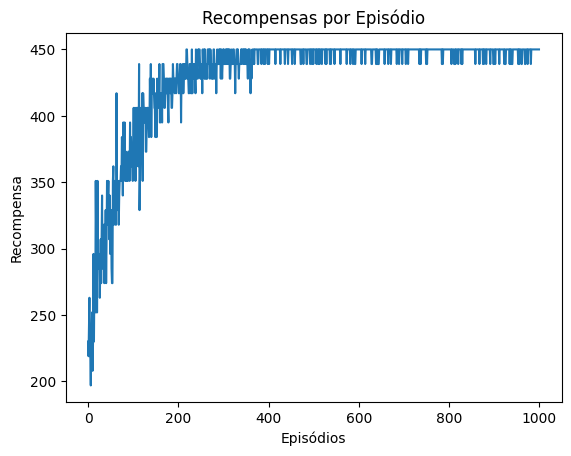

In [8]:
# Executar o treinamento
if __name__ == '__main__':
    env = DiabetesEnv()
    q_table, rewards = q_learning(env)

    # Exibir a Q-table final
    print("Q-table Final:")
    print(q_table)

    # Avaliar o agente
    # Parâmetros para avaliação
    max_steps_per_episode = 100
    num_episodes = 1000
    eval_seed = np.random.randint(0, 1000, size=num_episodes)  # cria uma lista de seeds para cada episódio

    mean_reward, std_reward = evaluate_agent(env, max_steps_per_episode, num_episodes, q_table, eval_seed)
    print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

    # Plotar recompensas
    plot_rewards(rewards)